In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

#unzip the zip files
!unzip /content/drive/MyDrive/EE769_project/Temperature_And_Precipitation_Cities_IN.zip


Archive:  /content/drive/MyDrive/EE769_project/Temperature_And_Precipitation_Cities_IN.zip
   creating: Temperature_And_Precipitation_Cities_IN/
  inflating: Temperature_And_Precipitation_Cities_IN/Bangalore_1990_2022_BangaloreCity.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Chennai_1990_2022_Madras.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Delhi_NCR_1990_2022_Safdarjung.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Lucknow_1990_2022.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Rajasthan_1990_2022_Jodhpur.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/Station_GeoLocation_Longitute_Latitude_Elevation_EPSG_4326.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/weather_Bhubhneshwar_1990_2022.csv  
  inflating: Temperature_And_Precipitation_Cities_IN/weather_Rourkela_2021_2022.csv  


In [2]:
%%capture
# load the dataset
dataframe_yearLong = read_csv('/content/Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv', usecols=[0,4])





#we try to extract only the

dataframe_yearLong['date'] = pd.to_datetime(dataframe_yearLong['time'],infer_datetime_format=True)  #convert time column to datetime format 

mask = (dataframe_yearLong['date'] > '2009-1-1') & (dataframe_yearLong['date'] <= '2015-12-31')  #create mask between selected dates

dataframe_yearLong= dataframe_yearLong.loc[mask]
dataframe_yearLong['prcp'] = dataframe_yearLong['prcp'].fillna(0) #to replace NaN with zero reference: https://datatofish.com/replace-nan-values-with-zeros/


# plt.plot(dataframe_yearLong)
dataframe_yearLong=pd.DataFrame(dataframe_yearLong, columns = ['prcp']  ) #only take prcp column

In [3]:
# we need to do the imputation

import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(dataframe_yearLong)

dataframe_yearLong=imp.transform(dataframe_yearLong)
dataframe_yearLong=pd.DataFrame(dataframe_yearLong, columns = ['rainfall']  )     #convert numpy array to dataframe



In [4]:
from sklearn.preprocessing import StandardScaler
dataset = dataframe_yearLong.values
dataset = dataset.astype('float32') #COnvert values to float


def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





seq_size = 10  

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))



# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # model = mdl


from sklearn.svm import SVR

model = SVR(kernel='rbf',max_iter=100)


model.fit(trainX, trainY)




trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict=trainPredict.reshape(-1, 1)
testPredict=testPredict.reshape(-1, 1)


Shape of training set: (1675, 10)
Shape of test set: (858, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Train Score: 27.11 RMSE
Test Score: 29.18 RMSE


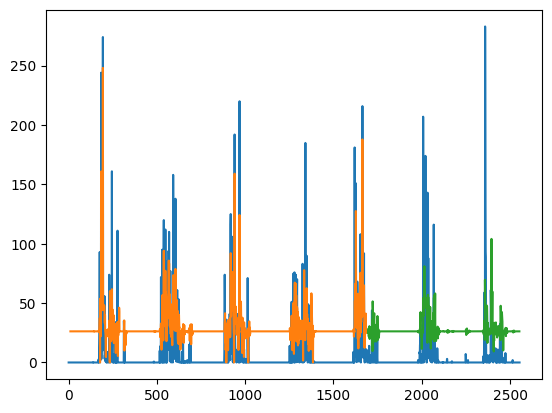

In [5]:

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
trainPredict[trainPredict<0] = 0
testPredict[testPredict<0] = 0


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot 
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [6]:
def run_model_SVR(data_frame,mdl,seq_size):
  dataset = data_frame.values

  scaler = MinMaxScaler(feature_range=(0, 1)) 
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size  
  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  model=mdl
  model.fit(trainX, trainY)


# make predictions

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict=trainPredict.reshape(-1, 1)
  testPredict=testPredict.reshape(-1, 1)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  #clamp the negative values to 0
  trainPredict[trainPredict<0] = 0
  testPredict[testPredict<0] = 0


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))


  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  return trainScore,testScore

In [7]:
%%capture
seqSize=[5,10,15,20,25,30,35,40,45,50,55,60]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = SVR(kernel='rbf',max_iter=100)

  
  tr,tst = run_model_SVR(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)



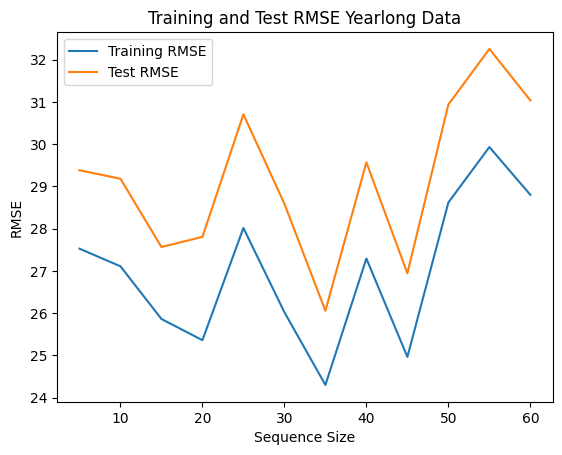

In [8]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

Train Score: 23.24 RMSE
Test Score: 21.75 RMSE


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


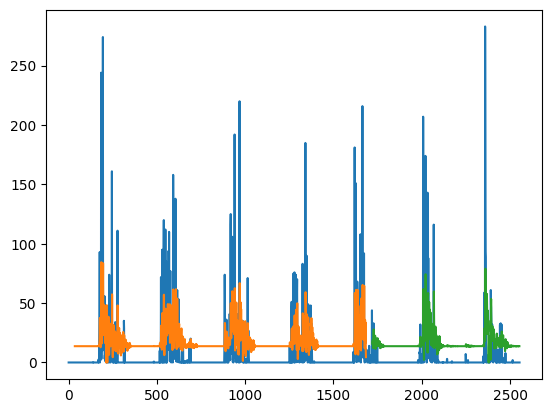

In [9]:
#reference :https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

seq_size=35

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.01,0.1,1, 10],'max_iter':[100,1000,5000]}
svr = SVR()
clf = GridSearchCV(svr, parameters)

tr,tst = run_model_SVR(dataframe_yearLong,clf,seq_size)



In [10]:
clf.best_estimator_

SVR(C=1, kernel='linear', max_iter=100)

In [11]:
dataframe_yearLong_diff=dataframe_yearLong.to_numpy()   #convert to numpy array reference:https://www.geeksforgeeks.org/pandas-dataframe-to_numpy-convert-dataframe-to-numpy-array/
dataframe_yearLong_diff_dummy=dataframe_yearLong_diff.copy()
for i in range (0,len(dataframe_yearLong_diff)-1):
  dataframe_yearLong_diff_dummy[i]=dataframe_yearLong_diff[i+1]-dataframe_yearLong_diff[i]

dataframe_yearLong_diff=dataframe_yearLong_diff_dummy



In [12]:
#convert back to dataframe

dataframe_yearLong_diff=pd.DataFrame(dataframe_yearLong_diff, columns = ['rainfall']  )     #convert numpy array to dataframe


In [13]:
def run_model_SVR_diffData(data_frame,mdl,seq_size):
  data_frame_orig=data_frame.copy() #preserve original data for later use
  data_frame=data_frame.to_numpy()   #convert to numpy array reference:https://www.geeksforgeeks.org/pandas-dataframe-to_numpy-convert-dataframe-to-numpy-array/
  data_frame_dummy=data_frame.copy()
  for i in range (1,len(data_frame)):
    data_frame_dummy[i]=data_frame[i]-data_frame[i-1]

  data_frame=data_frame_dummy
#convert back to dataframe

  data_frame=pd.DataFrame(data_frame, columns = ['rainfall']  )     #convert numpy array to dataframe


  dataset = data_frame.values
  dataset_orig=data_frame_orig.values
 

  scaler=StandardScaler()
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]





  seq_size = seq_size  

  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  model=mdl
  model.fit(trainX, trainY)


# make predictions

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict=trainPredict.reshape(-1, 1)
  testPredict=testPredict.reshape(-1, 1)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  

  

  # scaler1 = MinMaxScaler(feature_range=(trainY.min, trainY.max)) #Also try QuantileTransformer
  # trainPredict = scaler1.fit_transform(trainPredict)
  # testPredict = scaler1.fit_transform(testPredict)
  


# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))

  

  

  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot
  plt.figure(figsize=(20, 20))
  plt.plot(scaler.inverse_transform(dataset))
  # plt.plot((dataset_orig))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  return trainScore,testScore

In [14]:
%%capture
seqSize=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,120,150,200,250,300]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = SVR(kernel='rbf',max_iter=100)

  
  tr,tst = run_model_SVR_diffData(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)


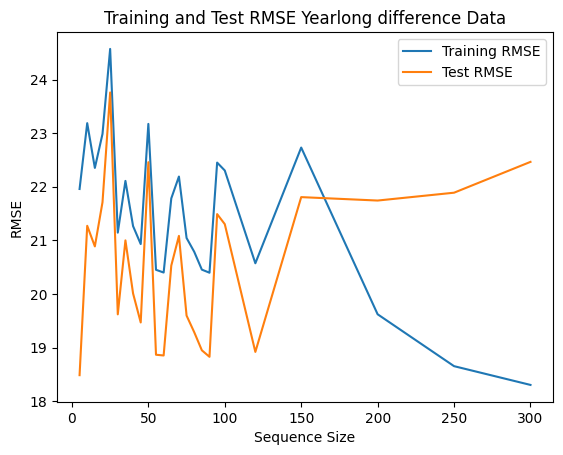

In [15]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE Yearlong difference Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

Train Score: 21.91 RMSE
Test Score: 17.22 RMSE


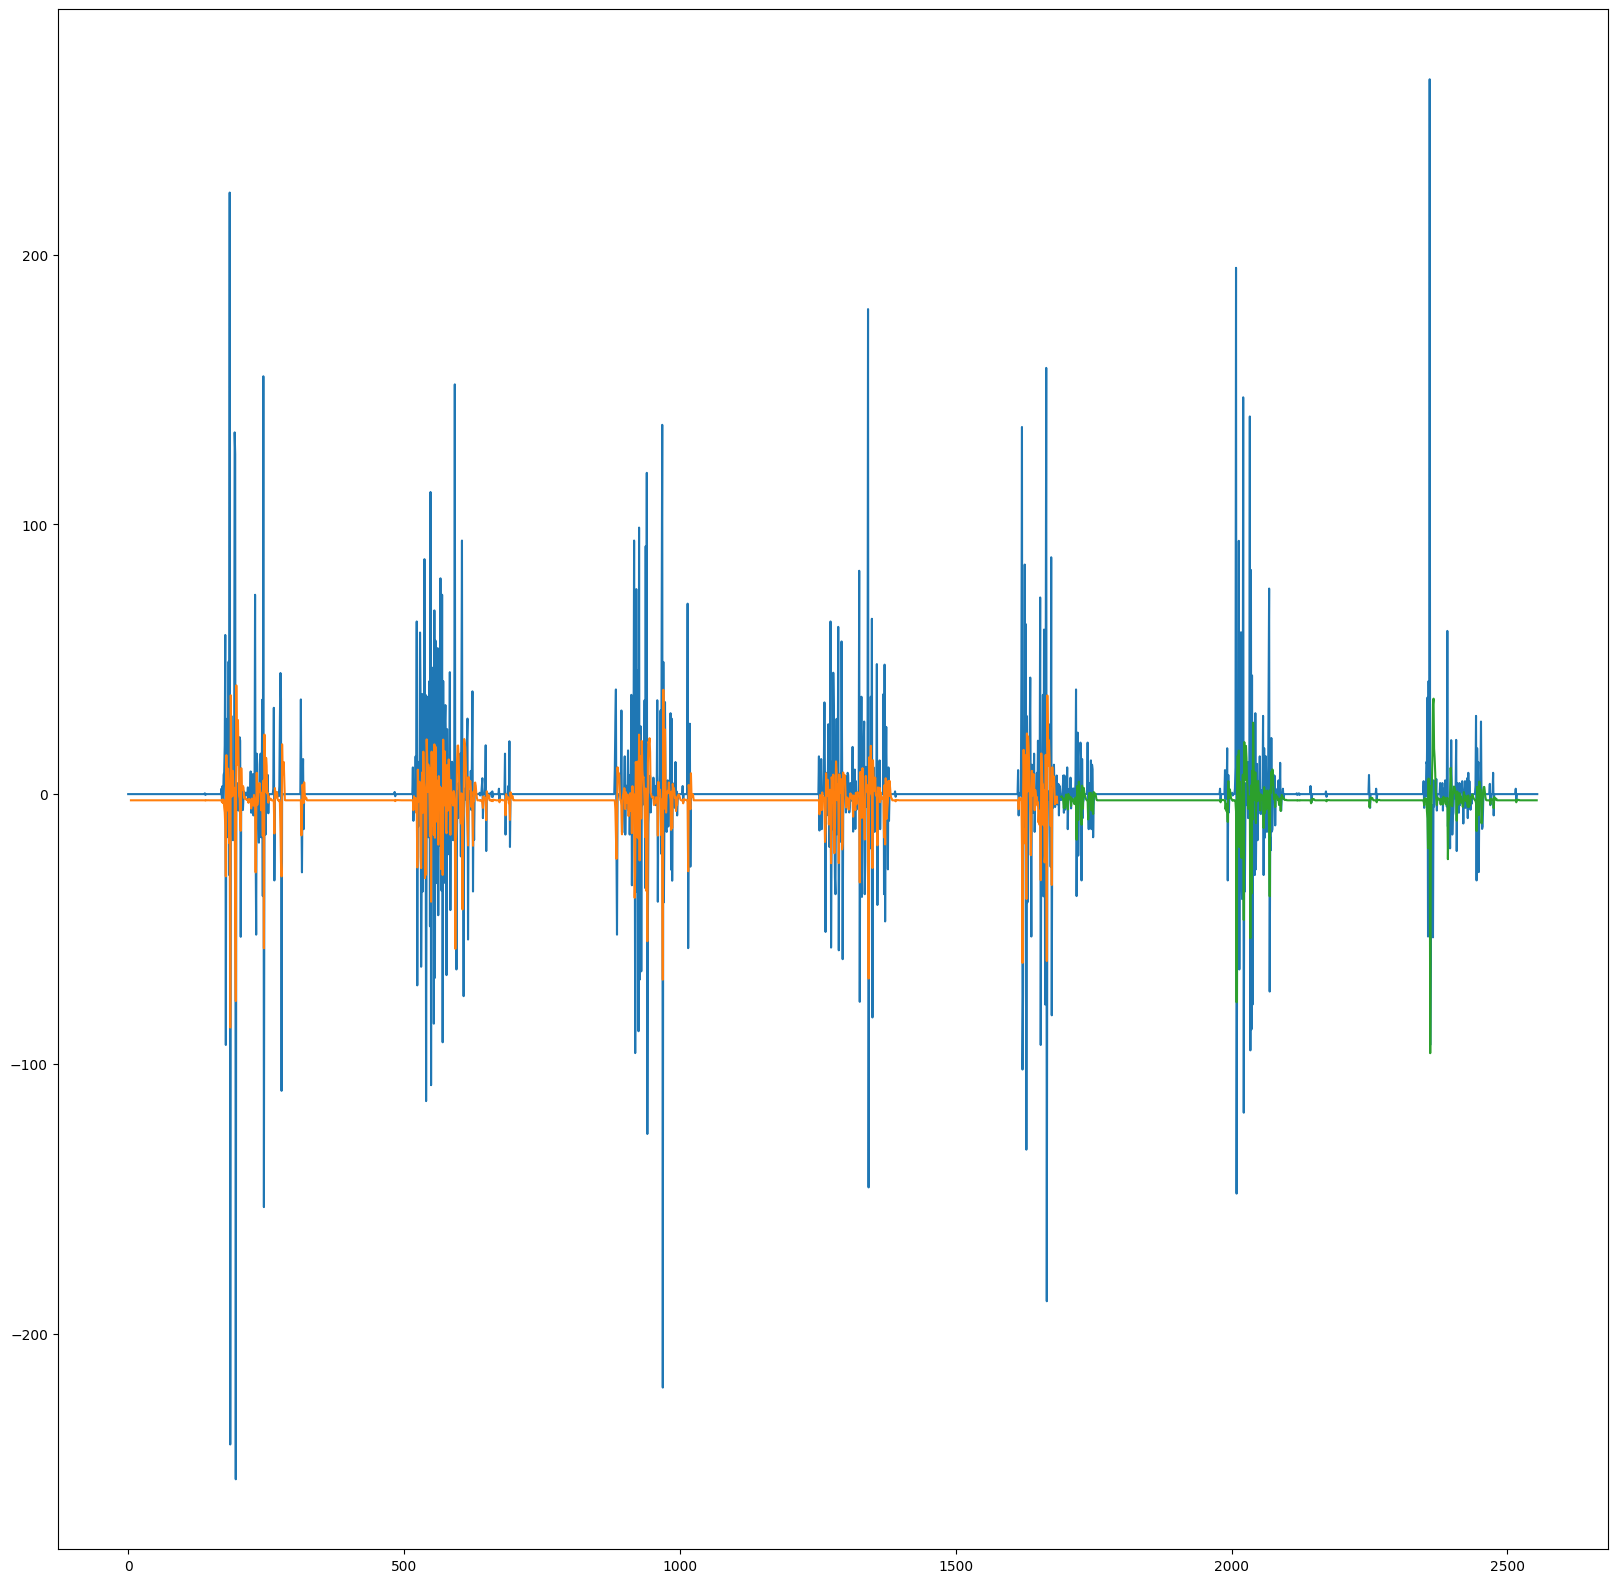

In [16]:
seq_size=5

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.001,0.01,0.1,1, 10],'max_iter':[100,1000,5000]}
svr = SVR()
clf = GridSearchCV(svr, parameters)

tr,tst = run_model_SVR_diffData(dataframe_yearLong,clf,seq_size)


In [17]:
clf.best_estimator_

SVR(C=0.1, kernel='linear', max_iter=5000)

Train Score: 21.91 RMSE
Test Score: 17.22 RMSE


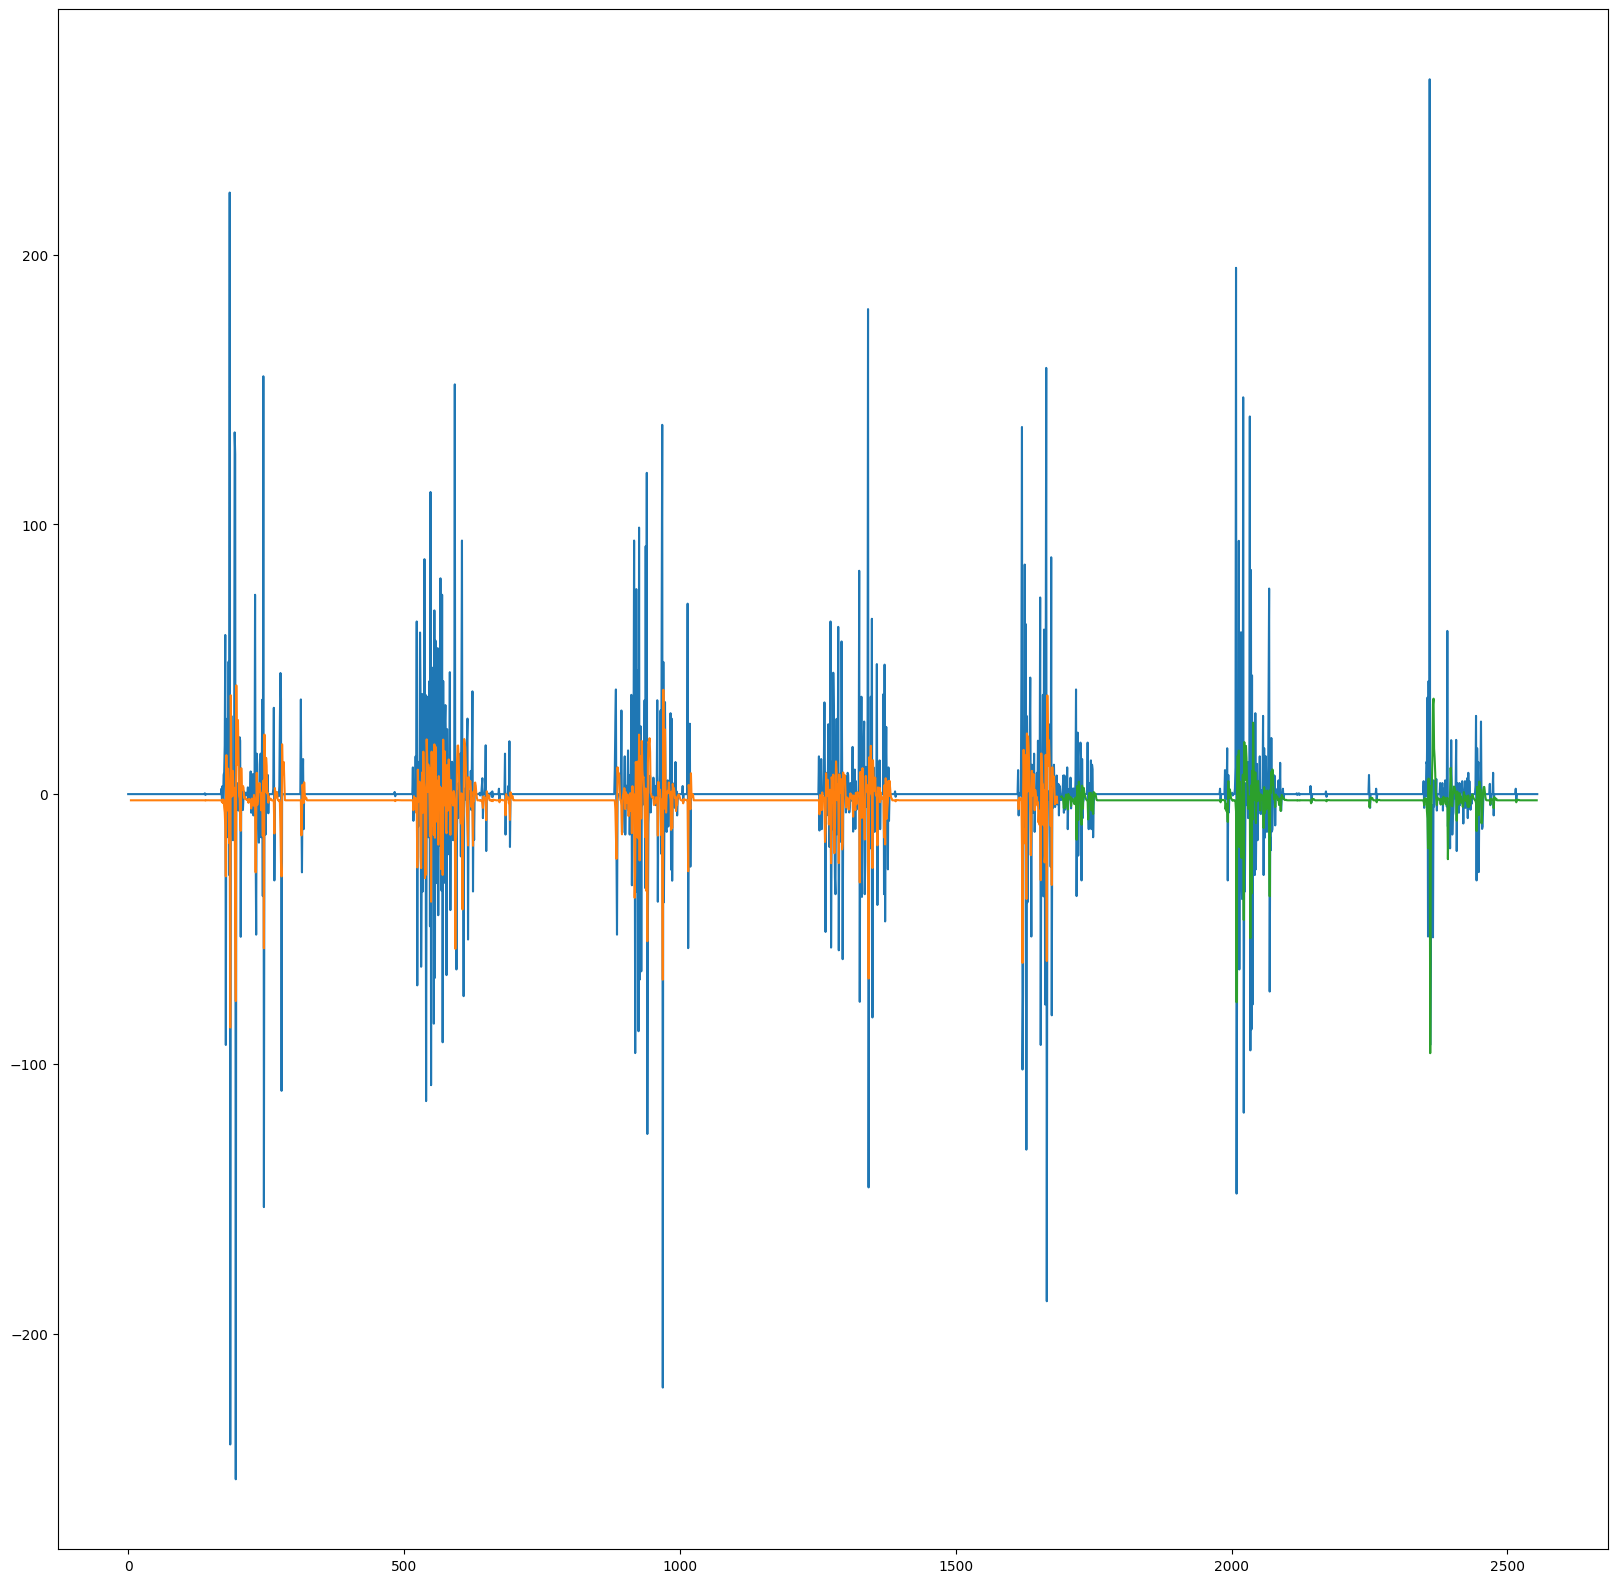

In [18]:
tr,tst = run_model_SVR_diffData(dataframe_yearLong,clf.best_estimator_,seq_size)

**LOGARITHMIC TRANSFORMATION**

We can try another transformation, that is logarithmic transformation, logarithmic transformation stretches out the higher and lower values, so that may help in improving the predictions

In [19]:
def run_model_SVR_LogData(data_frame,mdl,seq_size):
  data_frame_orig=data_frame.copy() #preserve original data for later use
  

  dataset = data_frame.values.astype(np.float64)
  dataset_orig=data_frame_orig.values

  dataset=np.log(dataset+1)
  print("log taken \n")

  
  scaler=StandardScaler()
  dataset = scaler.fit_transform(dataset)


  train_size = int(len(dataset) * 0.66)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  seq_size = seq_size  

  trainX, trainY = to_sequences(train, seq_size)
  testX, testY = to_sequences(test, seq_size)



  model=mdl
  model.fit(trainX, trainY)
  
# make predictions

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainPredict=trainPredict.reshape(-1, 1)
  testPredict=testPredict.reshape(-1, 1)


  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
   
  trainPredict = np.exp(trainPredict)
  trainY = np.exp(trainY)
  testPredict = np.exp(testPredict)
  testY =np.exp(testY)



# calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))

  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  # print(testY[0])
  # print( testPredict[:,0])
  # print(testY[0]-testPredict[:,0])
  # print("RMSE calculaated manually \n")
  # print(np.sqrt(np.sum(np.square(testY[0]-testPredict[:,0]))/testY[0].shape))


  # print(testPredict[:,0])

  

  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot
  plt.figure(figsize=(20, 20))
  # plt.plot(scaler.inverse_transform(dataset))
  plt.plot((dataset_orig))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.legend(["Original data","Training prediction","Test prediction"])
  plt.show()
  return trainScore,testScore

In [20]:
%%capture
seqSize=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,120,150,200,250,300]
seqSizeTrainScore=[]
seqSizeTestScore=[]


for i in seqSize:
  seq_size=i
  model = SVR(kernel='rbf',max_iter=100)

  
  tr,tst = run_model_SVR_LogData(dataframe_yearLong,model,seq_size)
  seqSizeTrainScore.append(tr)
  seqSizeTestScore.append(tst)


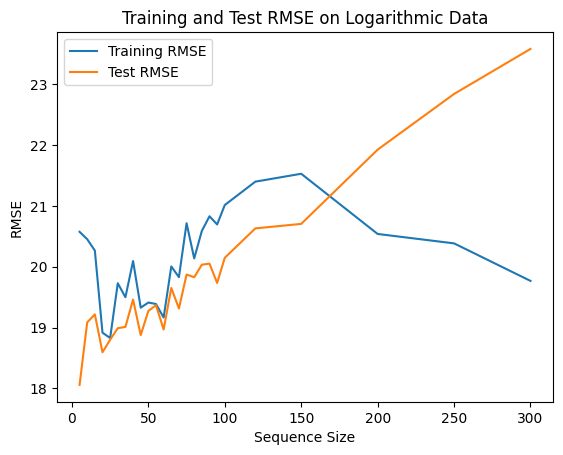

In [21]:
plt.plot(seqSize,seqSizeTrainScore)
plt.plot(seqSize,seqSizeTestScore)
plt.title("Training and Test RMSE on Logarithmic Data")
plt.xlabel("Sequence Size")
plt.ylabel("RMSE")
plt.legend(["Training RMSE","Test RMSE"])
plt.show()

log taken 

Train Score: 21.40 RMSE
Test Score: 17.58 RMSE


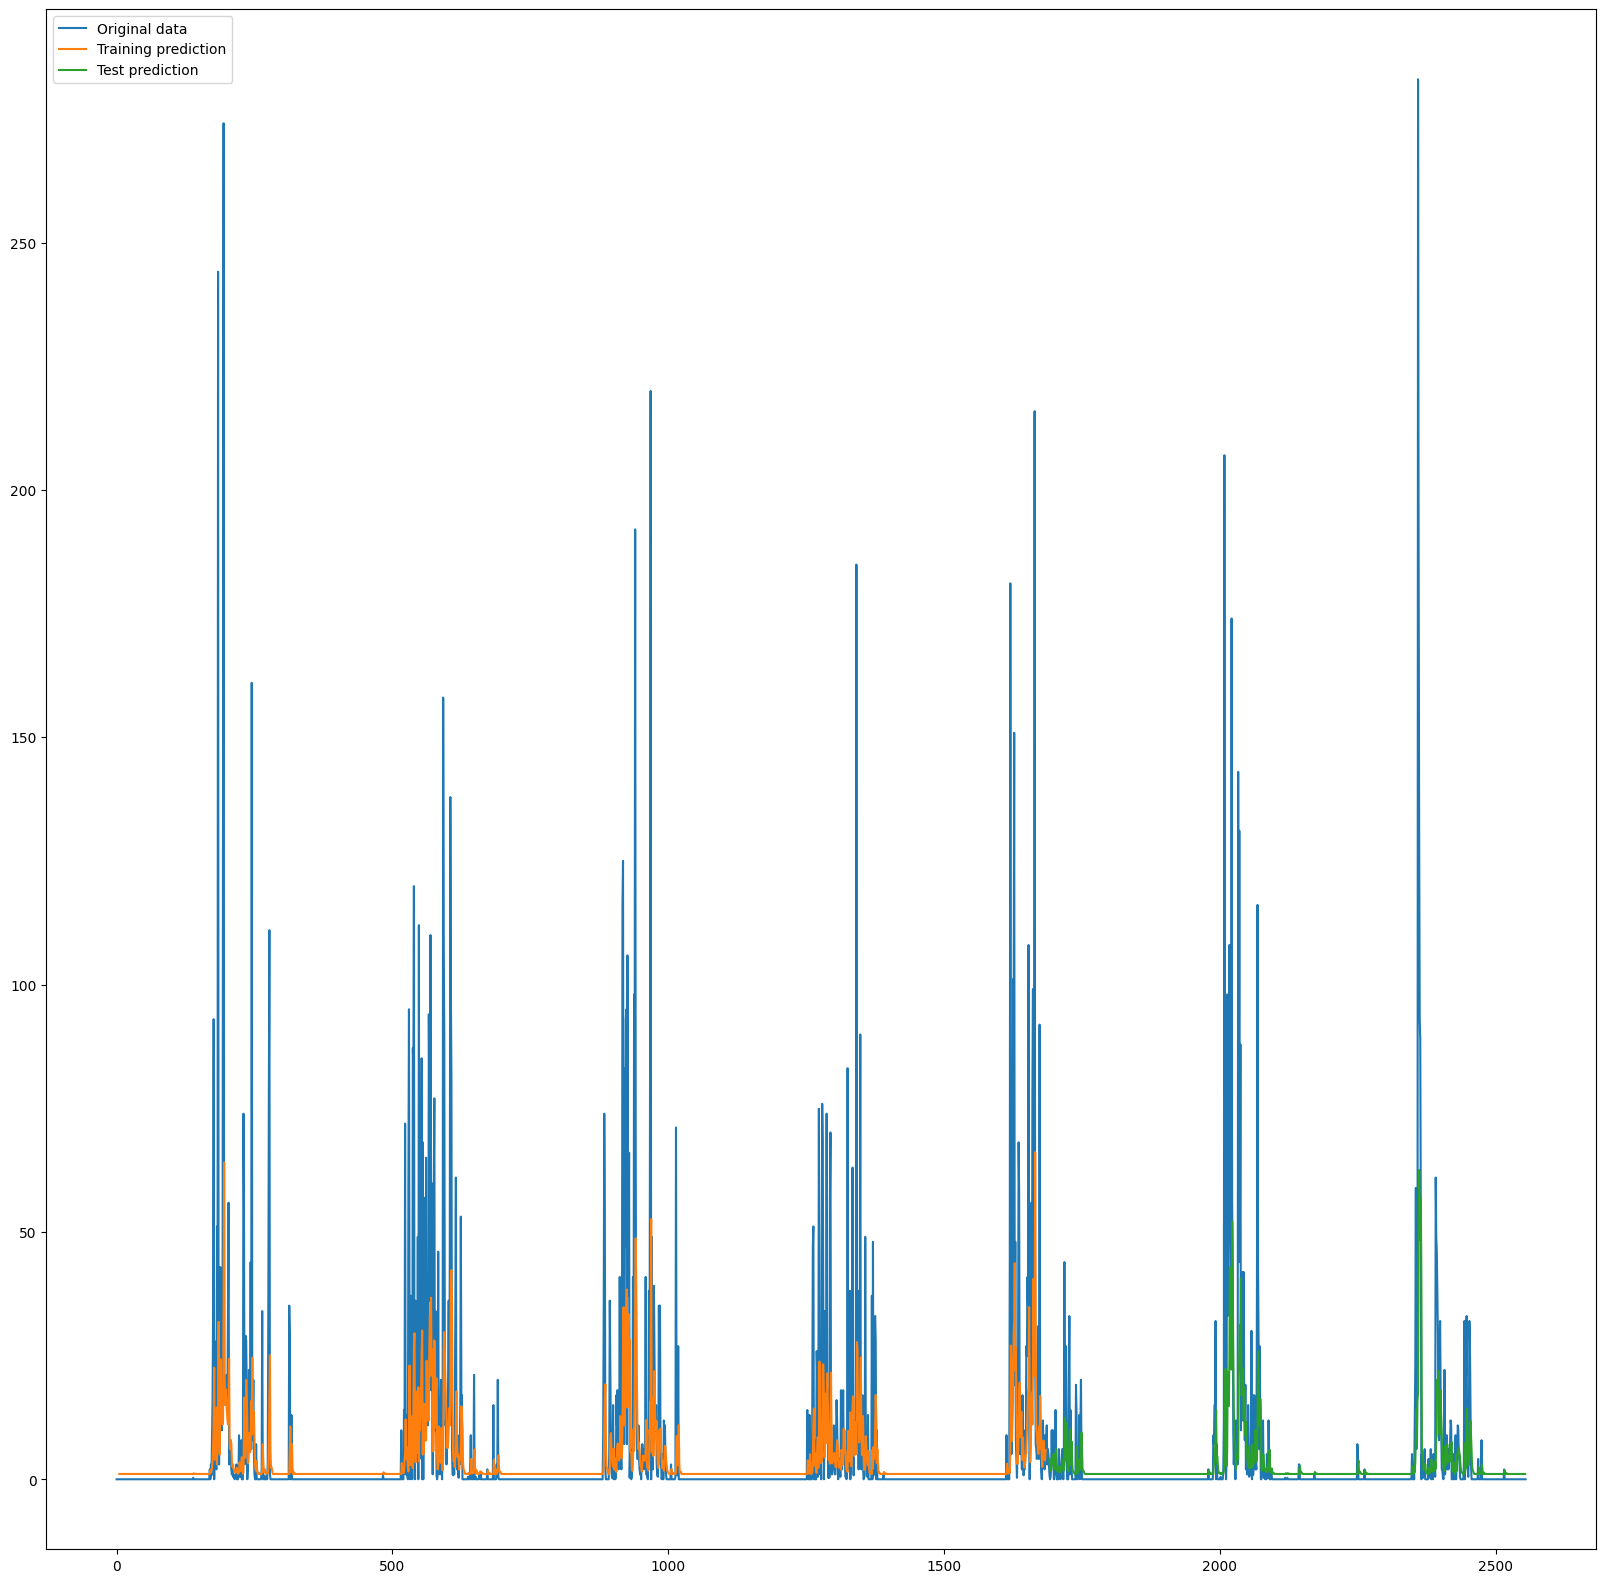

In [22]:
import warnings
warnings.filterwarnings('ignore')
seq_size=5

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C':[0.001,0.01,0.1,1, 10],'max_iter':[100,1000,5000]}
svr = SVR()
clf = GridSearchCV(svr, parameters)

tr,tst = run_model_SVR_LogData(dataframe_yearLong,clf,seq_size)


In [23]:
clf.best_estimator_

SVR(C=0.01, kernel='linear', max_iter=1000)

log taken 

Train Score: 21.40 RMSE
Test Score: 17.58 RMSE


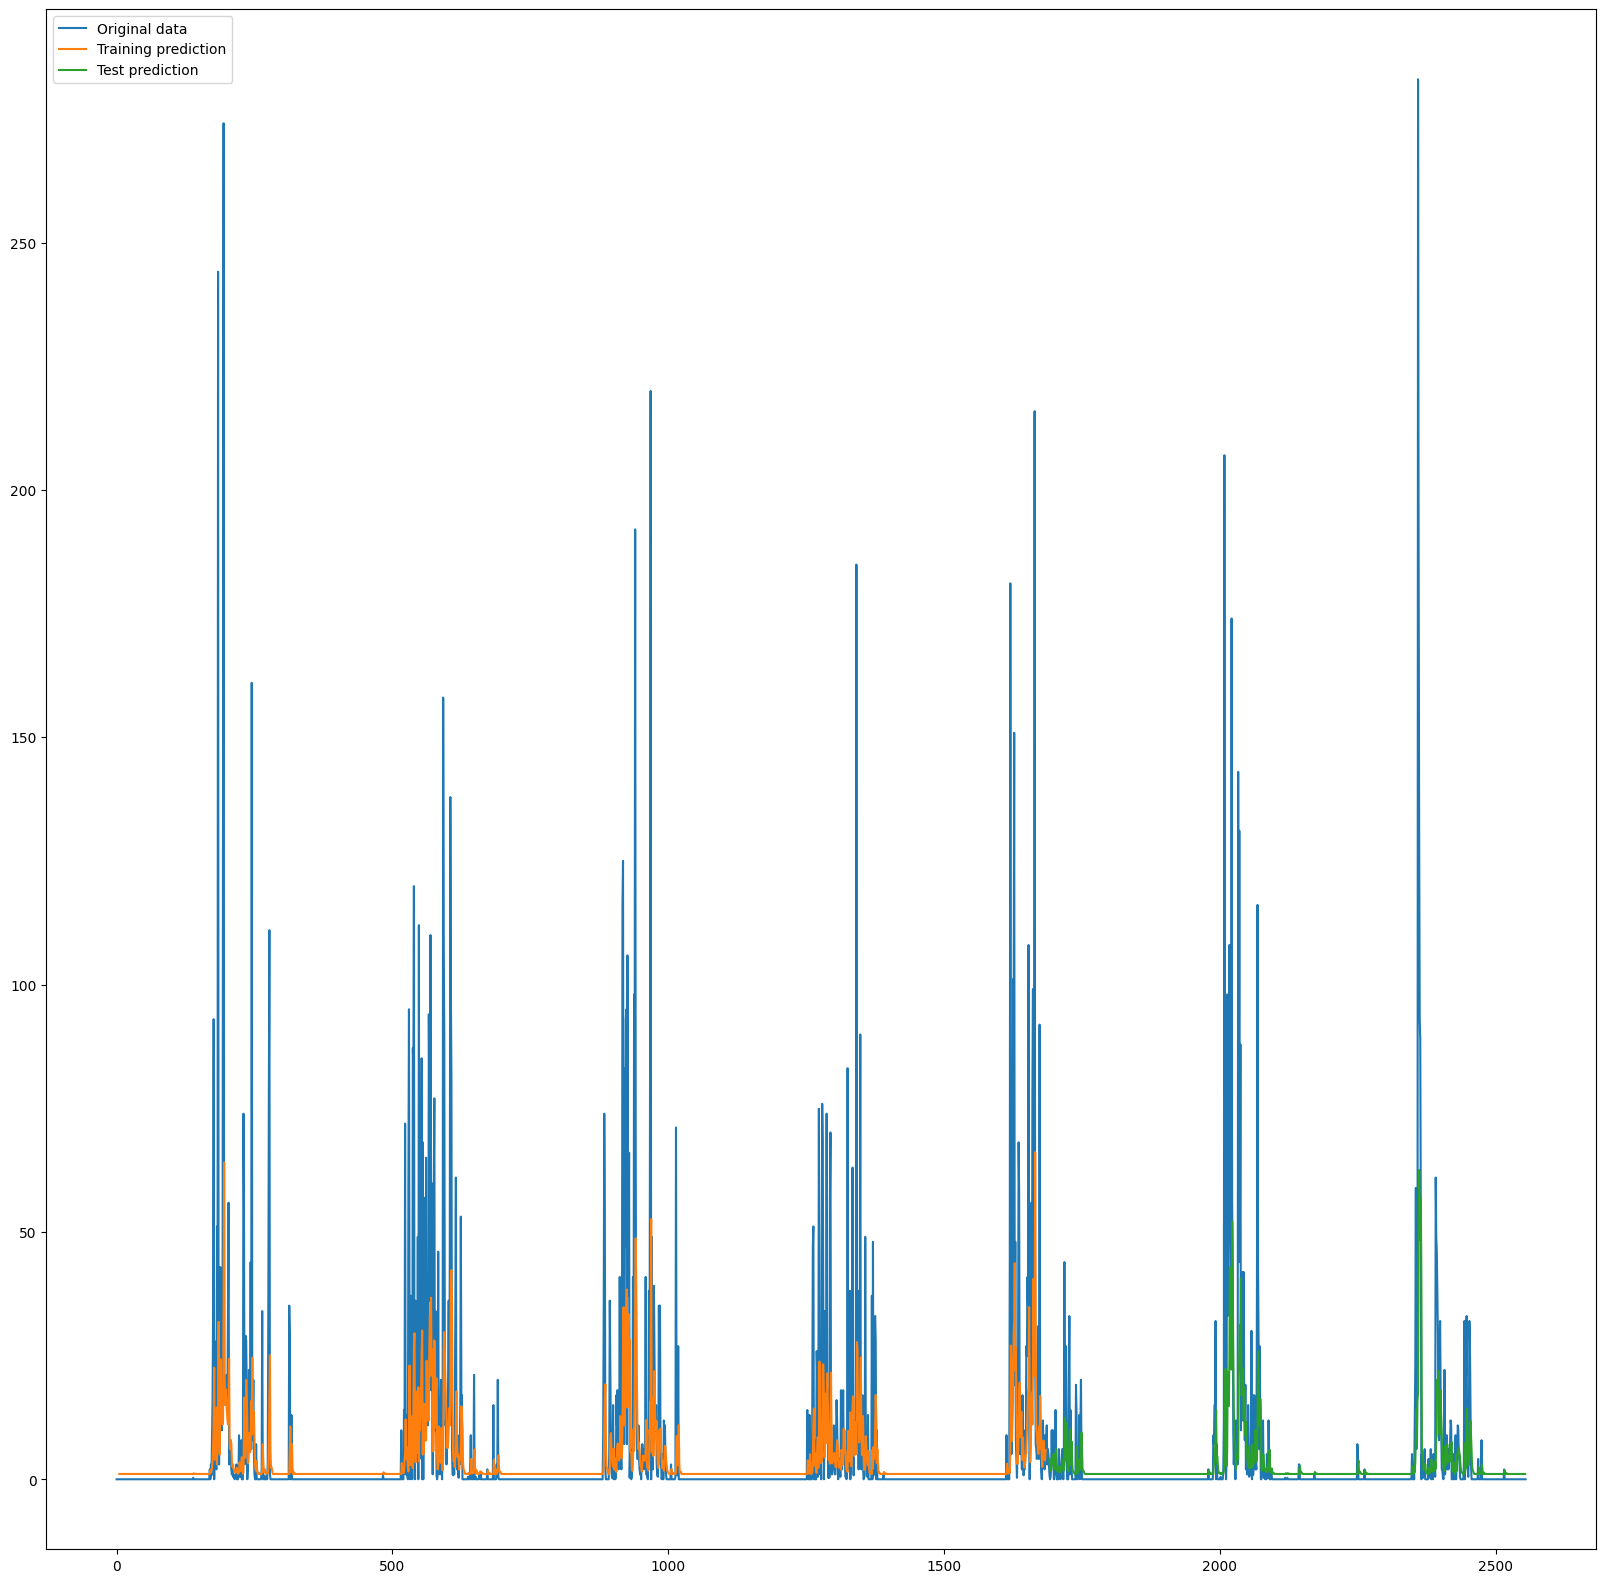

In [24]:
tr,tst = run_model_SVR_LogData(dataframe_yearLong,clf.best_estimator_,seq_size)